# Questions

In [6]:
# The packages necessary for running the code below
using PyPlot, LinearAlgebra, JLD2, Polynomials, JutulDarcyRules

In [7]:
# For the first time, run this cell twice to download data and then load the data
if ~isfile("BGCompass_tti.jld2")
    run(`wget -q -O BGCompass_tti.jld2 "https://www.dropbox.com/scl/fi/gs0eh2ldv9til0r7cg27n/BGCompass_tti.jld2?rlkey=bs2sil1ljiztl5bytlqghcm82&st=s5dnrjoh&dl=1"`)
else
    JLD2.@load "BGCompass_tti.jld2" m d
end

2-element Vector{Symbol}:
 :m
 :d

In [8]:
# Some necessary type conversions and defining size of velocity
v = Float64.(sqrt.(1f0./m));
d = Float64.(d);
n = size(v)

(325, 171)

In [9]:
# A basic function to find water bottom layer index values (You do not need to modify this)
function find_water_bottom(m::AbstractArray{avDT,2};eps = 1e-4) where {avDT}
    # return the indices of the water bottom of a seismic image
    n = size(m)
    idx = zeros(Integer, n[1])
    for j=1:n[1]
        k=1
        while true
            if abs(m[j,k]) > eps
                idx[j] = k
                break
            end
            k += 1
        end
    end
    return idx
end

# Changing velocity model to permeability
function VtoK(v::Matrix{T}, d::Tuple{T, T}; α::T=T(10)) where T

    n = size(v)
    idx_wb = find_water_bottom(v.-minimum(v))
    idx_ucfmt = find_water_bottom((v.-T(3.5)).*(v.>T(3.5)))
    Kh = zeros(T, n)
    capgrid = Int(round(T(50)/d[2]))
    for i = 1:n[1]
        Kh[i,1:idx_wb[i]-1] .= T(1e-10)  # water layer
        Kh[i,idx_wb[i]:idx_ucfmt[i]-capgrid-1] .= α*exp.(v[i,idx_wb[i]:idx_ucfmt[i]-capgrid-1])
        Kh[i,idx_ucfmt[i]-capgrid:idx_ucfmt[i]-1] .= T(1e-3)
        Kh[i,idx_ucfmt[i]:end] .= α*exp.(v[i,idx_ucfmt[i]:end]) .- T(320)
    end
    return Kh
end
Kh = VtoK(v, d);

# This part is used to create priority (You do not need to modify this)
idx_wb = find_water_bottom(v.-minimum(v));
idx_ucfmt = find_water_bottom((v.-3.5).*(v.>3.5))
phi = zeros(Float64,n)
for i = 1:n[1]
    for j = 1:n[2]
        p = Polynomial([-0.0314^2*Kh[i,j],2*0.0314^2*Kh[i,j],-0.0314^2*Kh[i,j],1.527^2]) 
        phi[i,j] = minimum(real(roots(p)[findall(real(roots(p)).== roots(p))]))
    end
    for j = idx_ucfmt[i]:idx_ucfmt[i]+8
        phi[i,idx_ucfmt[i]:idx_ucfmt[i]+8] = Float64.(range(0.056,stop=0.1,length=9))
    end
end

In [10]:
# We will use a subset of permeability model to make simulation faster .
Kh = Kh[151:240, :]
K = Float64.(Kh * JutulDarcyRules.md);
n = (size(K,1), 1, size(K,2))
d = (d[1], 50.0, d[2])
phi = phi[151:240, :]
phi_m = convert(Array{Float64,1},vec(phi));
ϕ = phi

# We set boundary values of porosity to 1e8. This will prevent over pressurization.
ϕ[1,:] .= 1e8
ϕ[:,1] .= 1e8
ϕ[end,:] .= 1e8
ϕ[:,end] .= 1e8
ϕ = convert(Array{Float64,1},vec(ϕ));

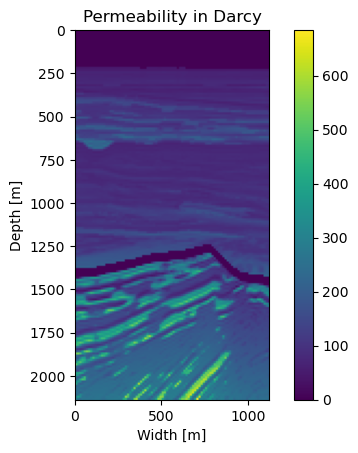

PyObject Text(0.5, 1.0, 'Permeability in Darcy')

In [11]:
# Plot permeability map 
imshow(Kh', extent = [0, size(Kh,1) *d[1], size(Kh,2) *d[3], 0]); colorbar(); xlabel("Width [m]"); ylabel("Depth [m]"); title("Permeability in Darcy")

In [12]:
# Create the model
model = jutulModel(n, d, ϕ, K1to3(K))

jutulModel{3, Float64}((90, 1, 171), (12.5, 50.0, 12.5), [1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8  …  1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8, 1.0e8], [9.86923266716013e-26 9.86923266716013e-26 … 2.436621876880626e-13 2.351440606894287e-13; 9.86923266716013e-26 9.86923266716013e-26 … 2.436621876880626e-13 2.351440606894287e-13; 9.86923266716013e-26 9.86923266716013e-26 … 2.436621876880626e-13 2.351440606894287e-13], 0.0)

In [13]:
# simulation time steppings (30 days between 2 time samples)
tstep = 30 * ones(100) # This corresponds to 3000 days. 30 is dt and 100 is number of time steps. Keep dt small for stability of solution
tot_time = sum(tstep)

## injection & production (source & sink) location
inj_loc = (5, 1, n[end]-10) .* d
prod_loc = (n[1]-3, 1, n[end]-10) .* d

# injectivity is in m^3 per sec
irate = 5e-2
q = jutulForce(irate, [inj_loc, prod_loc])

## set up modeling operator
S = jutulModeling(model, tstep)

## simulation
mesh = CartesianMesh(model)
T(x) = log.(KtoTrans(mesh, K1to3(exp.(x))))
logK = log.(K)
@time state = S(T(logK), q; info_level=1)

Jutul: Simulating 428 weeks, 4 days as 100 report steps
Step   1/100: Solving start to 4 weeks, 2 days, Δt = 4 weeks, 2 days 
Step   2/100: Solving 4 weeks, 2 days to 8 weeks, 4 days, Δt = 4 weeks, 2 days 
Step   3/100: Solving 8 weeks, 4 days to 12 weeks, 6 days, Δt = 4 weeks, 2 days 
Step   4/100: Solving 12 weeks, 6 days to 17 weeks, 1 day, Δt = 4 weeks, 2 days 
Step   5/100: Solving 17 weeks, 1 day to 21 weeks, 3 days, Δt = 4 weeks, 2 days 
Step   6/100: Solving 21 weeks, 3 days to 25 weeks, 5 days, Δt = 4 weeks, 2 days 
Step   7/100: Solving 25 weeks, 5 days to 30 weeks, Δt = 4 weeks, 2 days 
Step   8/100: Solving 30 weeks to 34 weeks, 2 days, Δt = 4 weeks, 2 days 
Step   9/100: Solving 34 weeks, 2 days to 38 weeks, 4 days, Δt = 4 weeks, 2 days 
Step  10/100: Solving 38 weeks, 4 days to 42 weeks, 6 days, Δt = 4 weeks, 2 days 
Step  11/100: Solving 42 weeks, 6 days to 47 weeks, 1 day, Δt = 4 weeks, 2 days 
Step  12/100: Solving 47 weeks, 1 day to 51 weeks, 3 days, Δt = 4 weeks, 2 d

3078000-element jutulStates{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 2.1359426506710764e7
 2.1358564024889007e7
 2.135696962880001e7
 2.135525710614737e7
 2.135422023336592e7
 2.135430011237757e7
 2.135544957914724e7
 2.135648684846326e7
 2.1359060922351018e7
 2.1362910749874525e7
 2.1367560687066786e7
 2.137222020299839e7

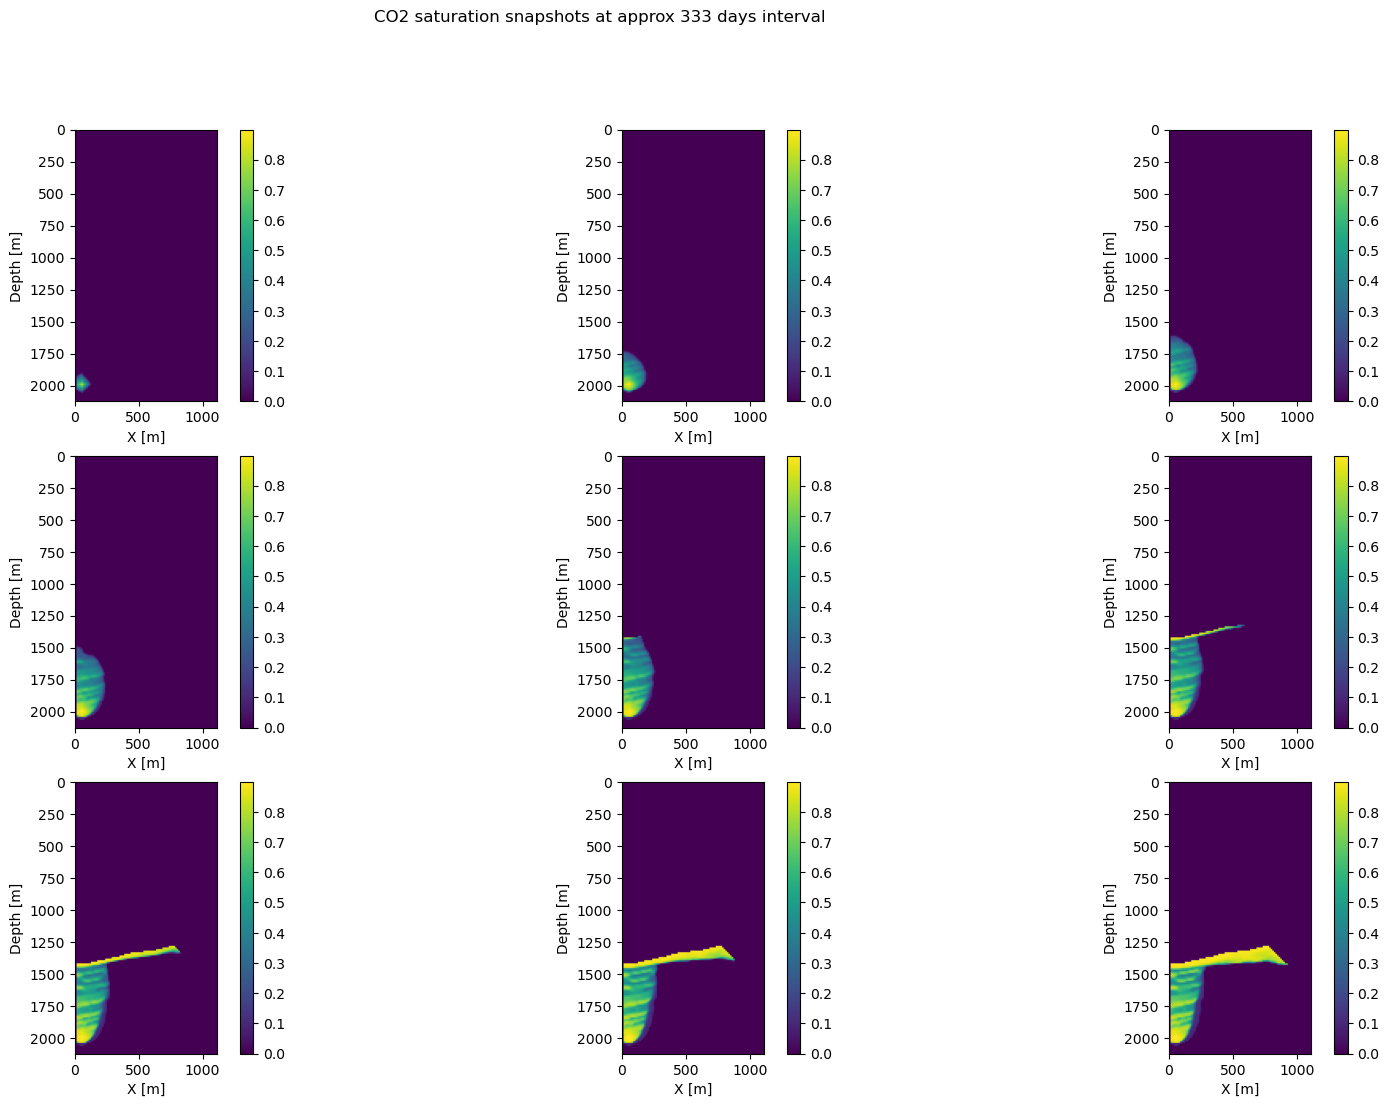

PyObject Text(0.5, 0.98, 'CO2 saturation snapshots at approx 333 days interval ')

In [14]:
# CO2 saturation snapshots
figure(figsize=(20,12));
obs=Int.(round.(range(1, stop=100, length=9))); # 9 observed time samples
for i = 1:9
    subplot(3,3,i)
    imshow(reshape(Saturations(state.states[obs[i]]), n[1], n[end])', extent=(0,(n[1]-1)*d[1],(n[3]-1)*d[3],0); vmin=0, vmax=maximum(Saturations(state.states[end])))
    xlabel("X [m]");ylabel("Depth [m]");
    colorbar()
end
suptitle("CO2 saturation snapshots at approx 333 days interval ")

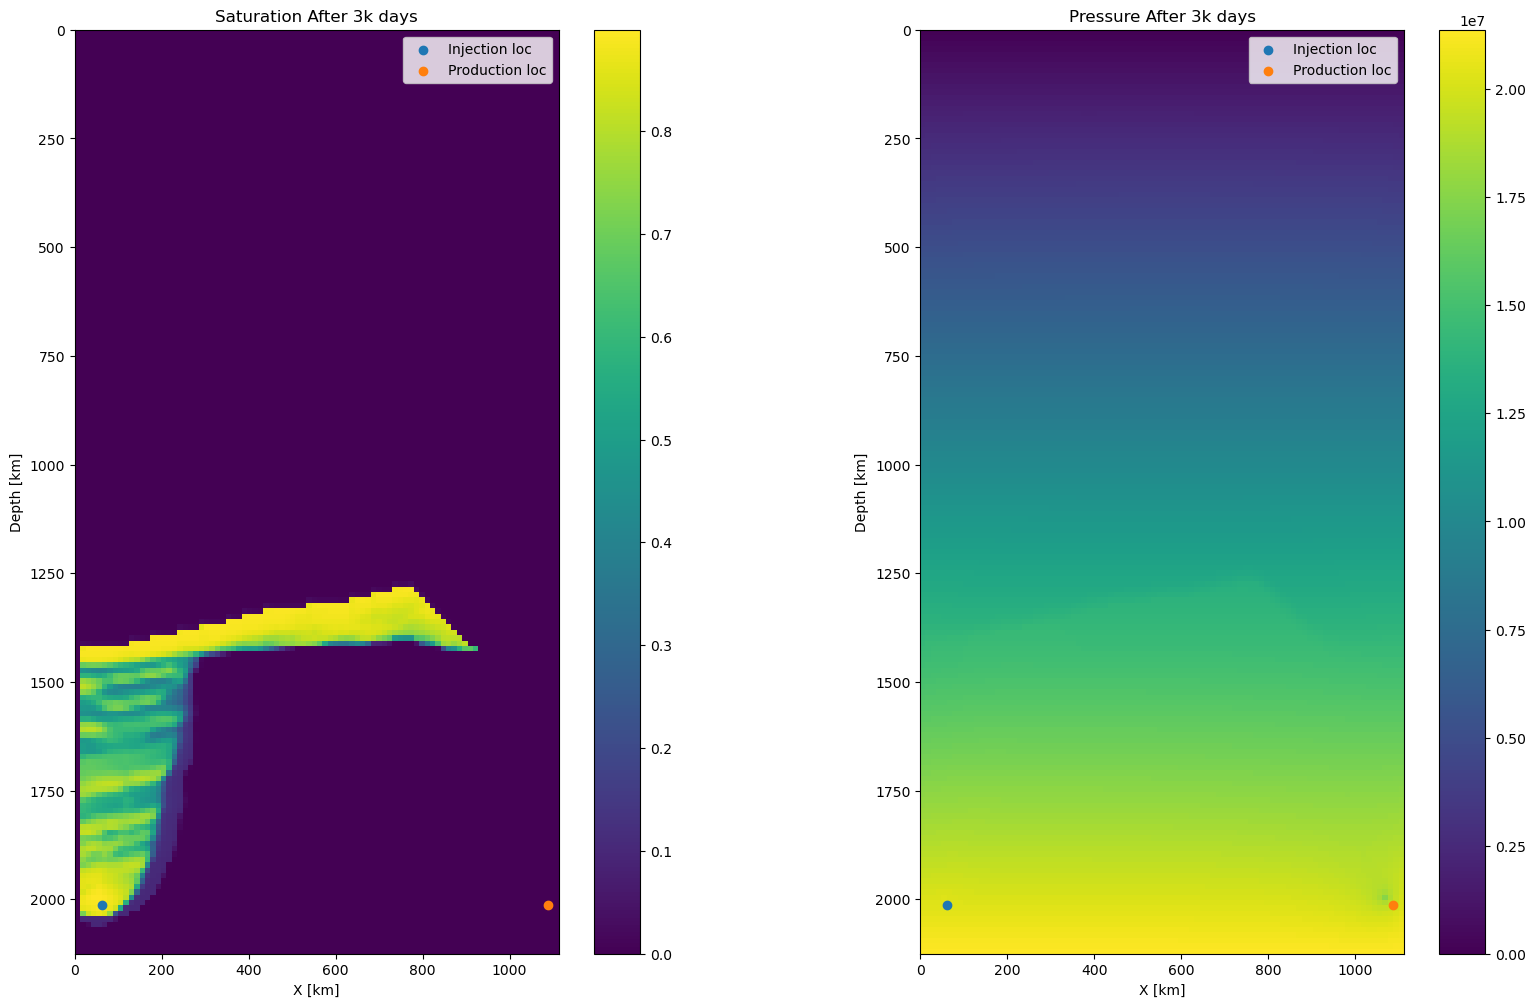

PyObject <matplotlib.legend.Legend object at 0x2aac4123e9c0>

In [15]:
fig=figure(figsize=(20,12));
#Plot Saturation at the end
subplot(1,2,1);
imshow(reshape(Saturations(state.states[end]), n[1], n[end])', extent=(0,(n[1]-1)*d[1],(n[3]-1)*d[3],0); vmin=0, vmax=maximum(Saturations(state.states[end]))); colorbar(); title("Saturation After 3k days")
xlabel("X [km]");ylabel("Depth [km]");
scatter(inj_loc[1],inj_loc[3])
scatter(prod_loc[1],inj_loc[3])
legend(["Injection loc","Production loc"])

#Plot Pressure at the end
subplot(1,2,2);
imshow(reshape(Pressure(state.states[end]), n[1], n[end])', extent=(0,(n[1]-1)*d[1],(n[3]-1)*d[3],0); vmin=0, vmax=maximum(Pressure(state.states[end]))); colorbar(); title("Pressure After 3k days")
xlabel("X [km]");ylabel("Depth [km]");
scatter(inj_loc[1],inj_loc[3])
scatter(prod_loc[1],inj_loc[3])
legend(["Injection loc","Production loc"])

In [16]:
maximum(Saturations(state.states[end]))

0.8984886621298521

In [17]:
# Save saturation and pressure data in JLD2 format
JLD2.@save "example_sat_press.jld2" state

Q1) What do you see in the time-varying CO2 saturation snapshots? How do
you interpret the movement of CO2? What role does production well
playing here? (20 marks)

Q2) What role does production well playing here? (20 marks)

Q2) The above experiment is for 3k days. Re-run the experiment for
different times such as 1k, 2k, 4k, and 5k days. Show saturation and
pressure maps for these days. Show total 8 images. (40 marks)

Q3) (a) Calculate the amount of CO2 in the reservoir after 300 days of
injection. (10 marks)

Q3) (b) Calculate the amount of CO2 in the reservoir at the end of
injection. (10 marks)

*(Hint: sum(state.states\[write array
index\].Saturations.*phi_m)*prod(model.d))*

Q4) Play with the seal region of permeability map to create a fault
(very high permeability 500 mD say) in small region of seal. Re-run the
experiment to see if CO2 leaks out from the seal. Showing saturation map
is enough here. (Bonus 10 point)